<h1><strong><u>K-Nearest Neighbors Model Selection</u></strong></h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

<h2><u>Data Preprocessing</u></h2>

In [2]:
df = pd.DataFrame(columns=["title", "target"])

In [3]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [4]:
data = df.sample(frac=1).reset_index(drop=True)
display(data)

,title,target
0,17 Things Only '00s Disney Kids Will Remember,clickbait
1,Drinking Underage Vs Drinking Legally,clickbait
2,What New Song Should You Listen To On Repeat T...,clickbait
3,We Know What Bodily Fluid Matches Your Persona...,clickbait
4,Which TV Show Should You Binge-Watch In 2016 B...,clickbait
...,...,...
31995,"Fear and loathing on the campaign trail, Octob...",non clickbait
31996,15 Super Bowl Snacks Worth Feasting On,clickbait
31997,No tsunamis after two major earthquakes strike...,non clickbait
31998,LaShawn Merritt and Sanya Richards Cruise to U...,non clickbait


In [5]:
X = data["title"]
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600,)

(6400,)

(25600,)

(6400,)

<h2><u>Data Vectorization</u></h2>

In [6]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h4><u>Cross Validation Testing</u></h4>

In [7]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)

[CV] END .................................clf__n_neighbors=1; total time=   2.0s
[CV] END .................................clf__n_neighbors=2; total time=   1.9s
[CV] END .................................clf__n_neighbors=3; total time=   1.9s
[CV] END .................................clf__n_neighbors=4; total time=   2.2s
[CV] END .................................clf__n_neighbors=5; total time=   2.2s
[CV] END .................................clf__n_neighbors=6; total time=   2.2s
[CV] END .................................clf__n_neighbors=1; total time=   1.9s
[CV] END .................................clf__n_neighbors=2; total time=   1.9s
[CV] END .................................clf__n_neighbors=3; total time=   2.0s
[CV] END .................................clf__n_neighbors=4; total time=   2.3s
[CV] END .................................clf__n_neighbors=5; total time=   2.2s
[CV] END .................................clf__n_neighbors=6; total time=   2.3s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.8min finished


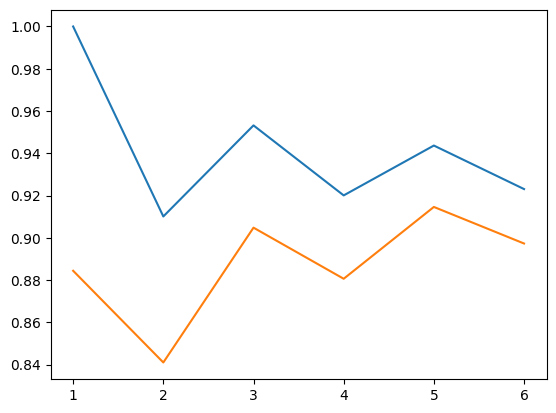

In [9]:
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__n_neighbors",
                                                   param_range=list(range(1,7)),
                                                   verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(list(range(1,7)), train_scores_mean)
plt.plot(list(range(1,7)), validation_scores_mean)

In [ ]:
param_grid = {
    "clf__n_neighbors": [51, 53, 55, 57, 59],
    "clf__weights": ["uniform", "distance"]
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)
knn_classifier = model.best_estimator_
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END clf__n_neighbors=51, clf__weights=uniform;, score=0.922 total time=  14.4s
[CV 1/5] END clf__n_neighbors=51, clf__weights=uniform;, score=0.932 total time=  14.4s
[CV 3/5] END clf__n_neighbors=51, clf__weights=uniform;, score=0.926 total time=  14.5s
[CV 1/5] END clf__n_neighbors=51, clf__weights=distance;, score=0.933 total time=  14.5s
[CV 5/5] END clf__n_neighbors=51, clf__weights=uniform;, score=0.929 total time=  16.9s
[CV 2/5] END clf__n_neighbors=51, clf__weights=uniform;, score=0.923 total time=  16.9s
[CV 2/5] END clf__n_neighbors=51, clf__weights=distance;, score=0.924 total time=  16.9s
[CV 3/5] END clf__n_neighbors=51, clf__weights=distance;, score=0.927 total time=  17.0s
[CV 2/5] END clf__n_neighbors=53, clf__weights=uniform;, score=0.925 total time=   6.8s
[CV 1/5] END clf__n_neighbors=53, clf__weights=uniform;, score=0.932 total time=   7.3s
[CV 4/5] END clf__n_neighbors=51, clf__weights=distance;

{'clf__n_neighbors': 53, 'clf__weights': 'distance'}

<h4><u>K-Nearest Neighbors Training Metrics</u></h4>

In [ ]:
knn_training_values = cross_val_score(knn_classifier, X_train, y_train, scoring='accuracy', cv=5)
print(f"Cross-validation Accuracy training scores: ", knn_training_values)
np_knn_training_values = np.array(knn_training_values)
average = np.mean(np_knn_training_values)
stDev = np.std(np_knn_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.93222656 0.92578125 0.92636719 0.92070312 0.93046875]
0.93  +/-  0.004 



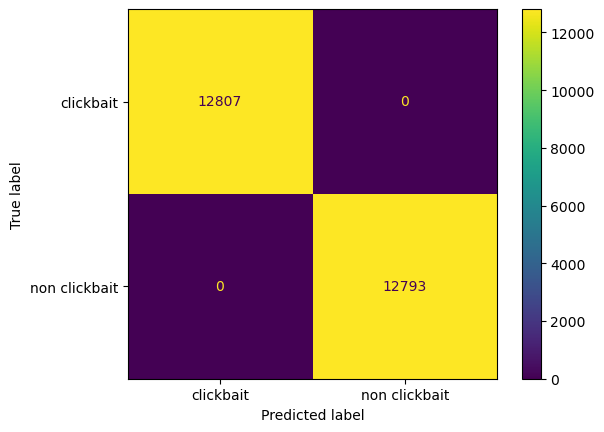

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train, y_train)

<h4><u>K-Nearest Neighbors Testing Metrics</u></h4>

In [ ]:
knn_test_predictions = knn_classifier.predict(X_test)

knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)
print("K-Nearest Neighbors Test Accuracy: {:.2f}%".format(knn_test_accuracy * 100))

K-Nearest Neighbors Test Accuracy: 92.52%


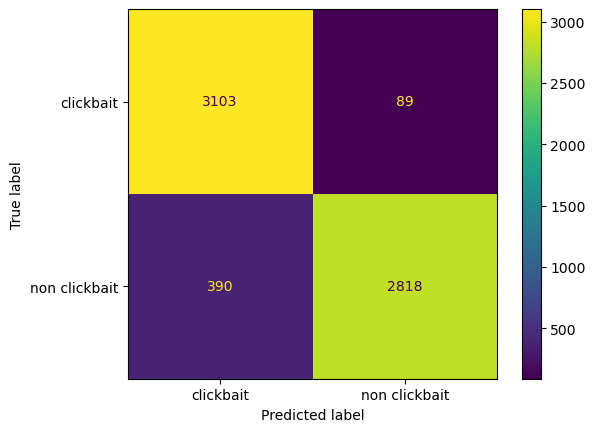

In [ ]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions)

<h4><u>K-Nearest Neighbors Learning Curves</u></h4>

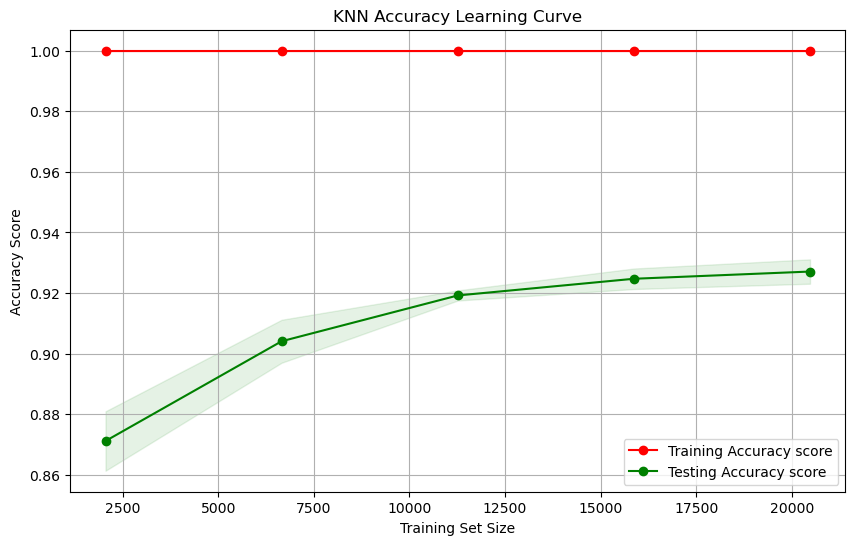

In [ ]:
knn_train_sizes, knn_train_scores, knn_test_scores = learning_curve(
    knn_classifier,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
knn_train_scores_std = np.std(knn_train_scores, axis=1)
knn_test_scores_mean = np.mean(knn_test_scores, axis=1)
knn_test_scores_std = np.std(knn_test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("KNN Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(knn_train_sizes, knn_train_scores_mean - knn_train_scores_std,
                knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(knn_train_sizes, knn_test_scores_mean - knn_test_scores_std,
                knn_test_scores_mean + knn_test_scores_std, alpha=0.1,
                color="g")
plt.plot(knn_train_sizes, knn_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(knn_train_sizes, knn_test_scores_mean, 'o-', color="g",
            label="Testing Accuracy score")

plt.legend(loc="best")
plt.show()